## [Computational Social Science] Project 5: Natural Language Processing (Julian Ramos)

In this project, you will use natural language processing techniques to explore a dataset containing tweets from members of the 116th United States Congress that met from January 3, 2019 to January 2, 2021. The dataset has also been cleaned to contain information about each legislator. Concretely, you will do the following:

* Preprocess the text of legislators' tweets
* Conduct Exploratory Data Analysis of the text
* Use sentiment analysis to explore differences between legislators' tweets
* Featurize text with manual feature engineering, frequency-based, and vector-based techniques
* Predict legislators' political parties and whether they are a Senator or Representative

You will explore two questions that relate to two central findings in political science and examine how they relate to the text of legislators' tweets. First, political scientists have argued that U.S. politics is currently highly polarized relative to other periods in American history, but also that the polarization is asymmetric. Historically, there were several conservative Democrats (i.e. "blue dog Democrats") and liberal Republicans (i.e. "Rockefeller Republicans"), as measured by popular measurement tools like [DW-NOMINATE](https://en.wikipedia.org/wiki/NOMINATE_(scaling_method)#:~:text=DW\%2DNOMINATE\%20scores\%20have\%20been,in\%20the\%20liberal\%2Dconservative\%20scale.). However, in the last few years, there are few if any examples of any Democrat in Congress being further to the right than any Republican and vice versa. At the same time, scholars have argued that this polarization is mostly a function of the Republican party moving further right than the Democratic party has moved left. **Does this sort of asymmetric polarization show up in how politicians communicate to their constituents through tweets?**

Second, the U.S. Congress is a bicameral legislature, and there has long been debate about partisanship in the Senate versus the House. The House of Representatives is apportioned by population and all members serve two year terms. In the Senate, each state receives two Senators and each Senator serves a term of six years. For a variety of reasons (smaller chamber size, more insulation from the voters, rules and norms like the filibuster, etc.), the Senate has been argued to be the "cooling saucer" of Congress in that it is more bipartisan and moderate than the House. **Does the theory that the Senate is more moderate have support in Senators' tweets?**

**Note**: See the project handout for more details on caveats and the data dictionary.

In [1]:
# pandas and numpy
import pandas as pd
import numpy as numpy

# punctuation, stop words and English language model
from string import punctuation
from spacy.lang.en.stop_words import STOP_WORDS
import en_core_web_sm
nlp = en_core_web_sm.load()

# textblob
from textblob import TextBlob

# countvectorizer, tfidfvectorizer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

# gensim
import gensim
from gensim import models

# plotting
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
# load data 
# ----------
congress_tweets = pd.read_csv("../../data/116th Congressional Tweets and Demographics.csv")
# fill in this line of code with a sufficient number of tweets, depending on your computational resources
congress_tweets = congress_tweets.sample(n=10000, random_state=5)
congress_tweets.head(100)

,tweet_id,screen_name,datetime,text,name_wikipedia,position,joined_congress_date,birthday,gender,state,district_number,party,trump_2016_state_share,clinton_2016_state_share,obama_2012_state_share,romney_2012_state_share
11361,1.132820e+18,SenDanSullivan,2019-05-26T21:36:32-04:00,Sam &amp; the guys had to deal with a less exp...,Dan Sullivan,Sen,3-Jan-15,11/13/1964,M,AK,Senate,Republican,"163,387","116,454","122,640","164,676"
479436,1.125490e+18,SenatorFischer,2019-05-06T16:15:46-04:00,It was great to @Skype w @StuartPublicSch’s go...,Deb Fischer,Sen,3-Jan-13,3/1/1951,F,NE,Senate,Republican,"495,961","284,494","302,081","475,064"
866557,1.166860e+18,RepDonBeyer,2019-08-28T19:44:44-04:00,RT @brianstelter 170 days.\n\nhttp://www.cnn.c...,Don Beyer,Rep,3-Jan-15,6/20/1950,M,VA,8,Democrat,"1,769,443","1,981,473","1,971,820","1,822,522"
168486,1.242860e+18,SenatorBennet,2020-03-25T13:14:12-04:00,@SenateDems We fought hard to make sure nonpro...,Michael Bennet,Sen,21-Jan-09,11/28/1964,M,CO,Senate,Democrat,"1,202,484","1,338,870","1,323,102","1,185,243"
507812,1.126490e+18,RepSires,2019-05-09T10:26:11-04:00,This illegal act shows once again there is no ...,Albio Sires,Rep,3-Jan-13,1/26/1951,M,NJ,8,Democrat,"1,601,933","2,148,278","2,125,101","1,477,568"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
417215,1.120770e+18,RepHaleyStevens,2019-04-23T15:39:13-04:00,"Today, I had the honor of hosting three of Mic...",Haley Stevens,Rep,3-Jan-19,6/24/1983,F,MI,11,Democrat,"2,279,543","2,268,839","2,564,569","2,115,256"
816750,1.269690e+18,RepKayGranger,2020-06-07T14:00:00-04:00,Attention #ParkerCounty small business owners:...,Kay Granger,Rep,3-Jan-97,1/18/1943,F,TX,12,Republican,"4,685,047","3,877,868","3,308,124","4,569,843"
306943,1.302060e+18,SenDuckworth,2020-09-04T21:49:56-04:00,When only 30% of our troops who have experienc...,Tammy Duckworth,Sen,3-Jan-17,3/12/1968,F,IL,Senate,Democrat,"2,146,015","3,090,729","3,019,512","2,135,216"
547830,1.318920e+18,MartinHeinrich,2020-10-21T10:06:39-04:00,The Trump administration's tactics against mig...,Martin Heinrich,Sen,3-Jan-13,10/17/1971,M,NM,Senate,Democrat,"319,667","385,234","415,335","335,788"


## Preprocessing

The first step in working with text data is to preprocess it. Make sure you do the following:

* Remove punctuation and stop words. The `rem_punc_stop()` function we used in lab is provided to you but you should feel free to edit it as necessary for other steps
* Remove tokens that occur frequently in tweets, but may not be helpful for downstream classification. For instance, many tweets contain a flag for retweeting, or share a URL 

As you search online, you might run into solutions that rely on regular expressions. You are free to use these, but you should also be able to preprocess using the techniques we covered in lab. Specifically, we encourage you to use spaCy's token attributes and string methods to do some of this text preprocessing.

In [3]:
def rem_punc_stop(text):
    stop_words = STOP_WORDS
    
    nlp.Defaults.stop_words |= {"RT", "QT","amp", "http"}
    
    punc = set(punctuation)
    
    punc_free = "".join([ch for ch in text if ch not in punc])
    
    doc = nlp(punc_free)
    
    spacy_words = [token.text for token in doc]
    
    spacy_words = [word for word in spacy_words if not word.startswith('http') and word != 'RT' and word != 'QT' and word != 'amp']

    
    no_punc = [word for word in spacy_words if word not in stop_words]
    
    return no_punc

In [4]:
congress_tweets['tokens'] = congress_tweets['text'].map(lambda x: rem_punc_stop(x)) # can use apply here 
congress_tweets['tokens'] # visualize

11361     [Sam, guys, deal, experienced, teammate, But, ...
479436    [It, great, Skype, w, StuartPublicSch, governm...
866557                      [brianstelter, 170, days, \n\n]
168486    [SenateDems, We, fought, hard, sure, nonprofit...
507812    [This, illegal, act, shows, rule, law, Maduro,...
                                ...                        
261279                                                   []
697356    [1200, NOT, Americans, wo, nt, survive, crisis...
86697     [We, opportunity, work, address, California, w...
439953    [MN, meeting, federal, clean, air, standards, ...
73974     [Meet, Cora, She, s, constituent, Kern, County...
Name: tokens, Length: 10000, dtype: object

In [5]:
list(STOP_WORDS)[0:21]

['them',
 'three',
 'besides',
 'wherever',
 'be',
 'done',
 'among',
 'thence',
 'alone',
 'many',
 'unless',
 'can',
 'they',
 'most',
 'before',
 'others',
 'upon',
 'about',
 'meanwhile',
 'their',
 '‘re']

In [6]:
list(STOP_WORDS)

['them',
 'three',
 'besides',
 'wherever',
 'be',
 'done',
 'among',
 'thence',
 'alone',
 'many',
 'unless',
 'can',
 'they',
 'most',
 'before',
 'others',
 'upon',
 'about',
 'meanwhile',
 'their',
 '‘re',
 'really',
 'RT',
 'nine',
 '’s',
 'will',
 'give',
 'why',
 'an',
 'whose',
 'see',
 'do',
 'formerly',
 '‘ve',
 'or',
 'behind',
 'more',
 'there',
 'thereupon',
 'until',
 'much',
 'anyone',
 'go',
 'part',
 'say',
 'often',
 'around',
 'off',
 'hereafter',
 'in',
 'he',
 'are',
 'fifteen',
 'various',
 'does',
 'himself',
 'any',
 'ourselves',
 "'re",
 'somewhere',
 'we',
 'although',
 'as',
 'may',
 'anyhow',
 'whereafter',
 'throughout',
 'onto',
 'anywhere',
 'would',
 'either',
 'anything',
 'of',
 'put',
 'hundred',
 'else',
 'where',
 'each',
 'call',
 'own',
 'within',
 'her',
 'latterly',
 'must',
 '’m',
 'whether',
 'ca',
 'such',
 'thereby',
 'over',
 'together',
 'one',
 'neither',
 'same',
 'thus',
 'however',
 'everywhere',
 'QT',
 "'m",
 'yourself',
 'always',
 

In [7]:
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

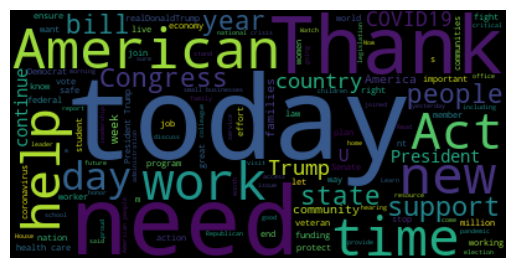

In [8]:
# now apply the function to all the columns in our dataframe
# These are showing our most frequent occurances in our dataset relative to the tokens
# ----------
# apply function to text object
text = ' '.join(congress_tweets['tokens'].map(lambda text: ' '.join(text)))

# create WordCloud visualization using the "text" object 
wordcloud = WordCloud(random_state=40).generate(text) # set random state to ensure same word cloud each time
                                                        # for workdcloud you can also change the presentation this is the default
    
# There are randoms states options . This allows diff lirbaries that sets a rand0m seed.

# plot 
plt.imshow(wordcloud,                  # specify wordcloud
           interpolation = 'bilinear') # specifies how the words are displayed
plt.axis('off')                        # turn off axes
plt.show()                             # show the plot

In [9]:
all_tokens = ' '.join([' '.join(words) for words in congress_tweets['tokens']])

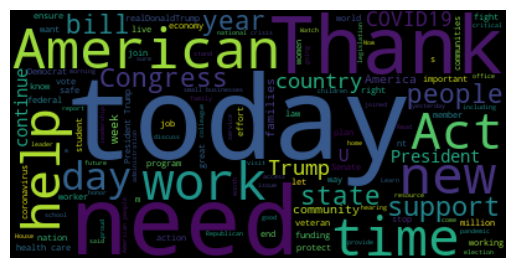

In [10]:
# now apply the function to all the columns in our dataframe
# These are showing our most frequent occurances in our dataset relative to the tokens
# ----------
# apply function to text object
text = ' '.join(congress_tweets['tokens'].map(lambda text: ' '.join(text)))

# create WordCloud visualization using the "text" object 
wordcloud = WordCloud(random_state=40).generate(text) # set random state to ensure same word cloud each time
                                                        # for workdcloud you can also change the presentation this is the default
    
# There are randoms states options . This allows diff lirbaries that sets a rand0m seed.

# plot 
plt.imshow(wordcloud,                  # specify wordcloud
           interpolation = 'bilinear') # specifies how the words are displayed
plt.axis('off')                        # turn off axes
plt.show()                             # show the plot

## Exploratory Data Analysis

Use two of the techniques we covered in lab (or other techniques outside of lab!) to explore the text of the tweets. You should construct these visualizations with an eye toward the eventual classification tasks: (1) predicting the legislator's political party based on the text of their tweet, and (2) predicting whether the legislator is a Senator or Representative. As a reminder, in lab we covered word frequencies, word clouds, word/character counts, scattertext, and topic modeling as possible exploration tools. 

### EDA 1

In [11]:
# create new feature columns with counts of # of characters and # of words
# ----------

# count number of characters. This applies length fucntion over every column
congress_tweets['text_len'] = congress_tweets['text'].apply(len)

# count number of words. Using this map function to iterate over each column we are taking each element in the lists we are splitting
# them and getting a count of each of those words. 
congress_tweets['word_count'] = congress_tweets['text'].apply(lambda x: len(str(x).split()))

/Users/jr/Desktop/anaconda3/envs/CSS/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


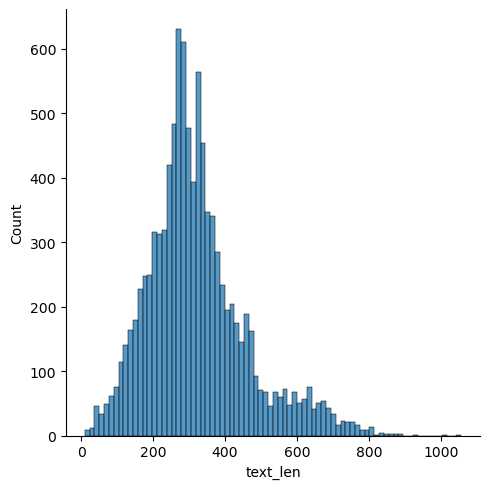

In [12]:
# create histogram of complaint length (number of characters)
sns.displot(congress_tweets,              # specify data
            x="text_len") # x-axis feature
plt.show()

In [13]:
print(congress_tweets[['text', 'text_len', 'word_count']].head())

                                                     text  text_len  \
11361   Sam &amp; the guys had to deal with a less exp...       281   
479436  It was great to @Skype w @StuartPublicSch’s go...       357   
866557  RT @brianstelter 170 days.\n\nhttp://www.cnn.c...       116   
168486  @SenateDems We fought hard to make sure nonpro...       217   
507812  This illegal act shows once again there is no ...       206   

        word_count  
11361           48  
479436          42  
866557           5  
168486          34  
507812          36  


In [14]:
print(congress_tweets[['text_len', 'word_count']].describe())

          text_len    word_count
count  10000.00000  10000.000000
mean     321.32170     38.145500
std      138.36405     16.624439
min       10.00000      1.000000
25%      236.00000     28.000000
50%      300.00000     38.000000
75%      382.00000     45.000000
max     1056.00000    109.000000


### EDA 2

In [15]:
pip install scattertext

Note: you may need to restart the kernel to use updated packages.


In [16]:
import scattertext as st

In [17]:
# Assuming 'tokens' is a column containing lists of tokens
# We'll create a new column 'text_str' by joining the tokens into a single string
congress_tweets['text_str'] = congress_tweets['tokens'].apply(lambda x: ' '.join(x))


In [18]:
# create measure of subjectivity
# ---------- 
corpus = st.CorpusFromPandas(congress_tweets[:10000],              # specify data
                             category_col = 'party', # specify the explanatory variable  
                             text_col = 'text_str',      # specify the text column
                             nlp = nlp).build()        # apply the nlp algorithim and build

In [19]:
# create html document
html = st.produce_scattertext_explorer(corpus,
                                       category='Democrat',
                                       category_name='Democrat',
                                       not_category_name='Republican',
                                       width_in_pixels=1000,
                                       minimum_term_frequency=5)

In [20]:
# create measure of subjectivity
# ---------- 
corpus = st.CorpusFromPandas(congress_tweets[:10000],              # specify data
                             category_col = 'party', # specify the explanatory variable  
                             text_col = 'text_str',      # specify the text column
                             nlp = nlp).build()        # apply the nlp algorithim and build

In [21]:
html = st.produce_scattertext_explorer(corpus,
                                       category='Democrat',           # This is the category you're focusing on
                                       category_name='Democrat',      # Name for the category in the visualization
                                       not_category_name='Republican',# Name for the contrasting category
                                       width_in_pixels=1000,
                                       minimum_term_frequency=5) # Ensure metadata matches corpus length


In [22]:
open("Congress_Tweets_Visualization.html", 'wb').write(html.encode('utf-8'))


4245213

In [23]:
import webbrowser

# Define the path to the HTML file
html_file = 'Congress_Tweets_Visualization.html'

# Open the HTML file in the default web browser
webbrowser.open_new_tab(html_file)

True

## Sentiment Analysis

Next, let's analyze the sentiments contained within the tweets. You may use TextBlob or another library for these tasks. Do the following:

* Choose two legislators, one who you think will be more liberal and one who you think will be more conservative, and analyze their sentiment and/or subjectivity scores per tweet. For instance, you might do two scatterplots that plot each legislator's sentiment against their subjectivity, or two density plots for their sentiments. Do the scores match what you thought?
* Plot two more visualizations like the ones you chose in the first part, but do them to compare (1) Democrats v. Republicans and (2) Senators v. Representatives 

`TextBlob` has already been imported in the top cell.

In [24]:
# create a feature colum of sentiment polarity. 
# Text blob is another apotion to the spacy library and you can check out what it does above. 
# Can do sentiment analysis, tokenization, word inflection and lemmenization. 

# ---------- 
# create the "tokens" column again . This can make sure this is clean overiding data already there if we creare a new name

congress_tweets['tokens'] = congress_tweets['tokens'].map(lambda text: ' '.join(text))

# create the "tokens" column again . Take text blob with string of each row from sentiment lirbary pull the polarity
congress_tweets['polarity'] = congress_tweets['tokens'].map(lambda text: TextBlob(text).sentiment.polarity)

# view
congress_tweets.head(100)

,tweet_id,screen_name,datetime,text,name_wikipedia,position,joined_congress_date,birthday,gender,state,...,party,trump_2016_state_share,clinton_2016_state_share,obama_2012_state_share,romney_2012_state_share,tokens,text_len,word_count,text_str,polarity
11361,1.132820e+18,SenDanSullivan,2019-05-26T21:36:32-04:00,Sam &amp; the guys had to deal with a less exp...,Dan Sullivan,Sen,3-Jan-15,11/13/1964,M,AK,...,Republican,"163,387","116,454","122,640","164,676",Sam guys deal experienced teammate But podium ...,281,48,Sam guys deal experienced teammate But podium ...,0.400000
479436,1.125490e+18,SenatorFischer,2019-05-06T16:15:46-04:00,It was great to @Skype w @StuartPublicSch’s go...,Deb Fischer,Sen,3-Jan-13,3/1/1951,F,NE,...,Republican,"495,961","284,494","302,081","475,064",It great Skype w StuartPublicSch government cl...,357,42,It great Skype w StuartPublicSch government cl...,0.733333
866557,1.166860e+18,RepDonBeyer,2019-08-28T19:44:44-04:00,RT @brianstelter 170 days.\n\nhttp://www.cnn.c...,Don Beyer,Rep,3-Jan-15,6/20/1950,M,VA,...,Democrat,"1,769,443","1,981,473","1,971,820","1,822,522",brianstelter 170 days \n\n,116,5,brianstelter 170 days \n\n,0.000000
168486,1.242860e+18,SenatorBennet,2020-03-25T13:14:12-04:00,@SenateDems We fought hard to make sure nonpro...,Michael Bennet,Sen,21-Jan-09,11/28/1964,M,CO,...,Democrat,"1,202,484","1,338,870","1,323,102","1,185,243",SenateDems We fought hard sure nonprofits size...,217,34,SenateDems We fought hard sure nonprofits size...,0.085417
507812,1.126490e+18,RepSires,2019-05-09T10:26:11-04:00,This illegal act shows once again there is no ...,Albio Sires,Rep,3-Jan-13,1/26/1951,M,NJ,...,Democrat,"1,601,933","2,148,278","2,125,101","1,477,568",This illegal act shows rule law Maduro Venezue...,206,36,This illegal act shows rule law Maduro Venezue...,-0.500000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
417215,1.120770e+18,RepHaleyStevens,2019-04-23T15:39:13-04:00,"Today, I had the honor of hosting three of Mic...",Haley Stevens,Rep,3-Jan-19,6/24/1983,F,MI,...,Democrat,"2,279,543","2,268,839","2,564,569","2,115,256",Today I honor hosting Michigan leading experts...,423,31,Today I honor hosting Michigan leading experts...,0.400000
816750,1.269690e+18,RepKayGranger,2020-06-07T14:00:00-04:00,Attention #ParkerCounty small business owners:...,Kay Granger,Rep,3-Jan-97,1/18/1943,F,TX,...,Republican,"4,685,047","3,877,868","3,308,124","4,569,843",Attention ParkerCounty small business owners A...,285,33,Attention ParkerCounty small business owners A...,0.007273
306943,1.302060e+18,SenDuckworth,2020-09-04T21:49:56-04:00,When only 30% of our troops who have experienc...,Tammy Duckworth,Sen,3-Jan-17,3/12/1968,F,IL,...,Democrat,"2,146,015","3,090,729","3,019,512","2,135,216",When 30 troops experienced sexual assault actu...,269,48,When 30 troops experienced sexual assault actu...,0.200000
547830,1.318920e+18,MartinHeinrich,2020-10-21T10:06:39-04:00,The Trump administration's tactics against mig...,Martin Heinrich,Sen,3-Jan-13,10/17/1971,M,NM,...,Democrat,"319,667","385,234","415,335","335,788",The Trump administrations tactics migrant chil...,529,53,The Trump administrations tactics migrant chil...,-0.400000


/Users/jr/Desktop/anaconda3/envs/CSS/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


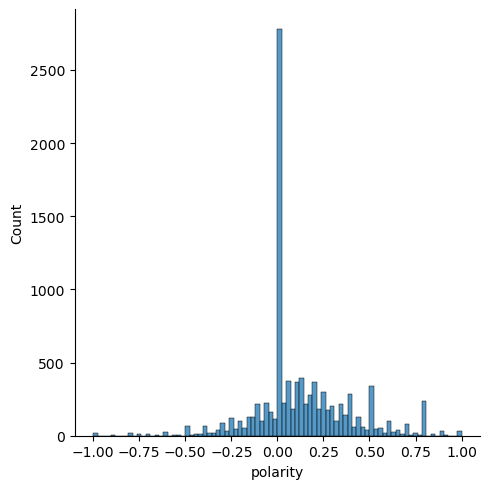

In [25]:
# histogram of polarity

# People may be descripting information factualy rather than. 
sns.displot(congress_tweets,         # specify data
            x="polarity") # x-axis label 
plt.show()

In [26]:
# create a feature colum of sentiment polarity. 
# Text blob is another apotion to the spacy library and you can check out what it does above. 
# Can do sentiment analysis, tokenization, word inflection and lemmenization. 

# ---------- 


# create the "tokens" column again . Take text blob with string of each row from sentiment lirbary pull the polarity
congress_tweets['polarity'] = congress_tweets['text_str'].map(lambda text: TextBlob(text).sentiment.polarity)

# view
congress_tweets.head(100)

,tweet_id,screen_name,datetime,text,name_wikipedia,position,joined_congress_date,birthday,gender,state,...,party,trump_2016_state_share,clinton_2016_state_share,obama_2012_state_share,romney_2012_state_share,tokens,text_len,word_count,text_str,polarity
11361,1.132820e+18,SenDanSullivan,2019-05-26T21:36:32-04:00,Sam &amp; the guys had to deal with a less exp...,Dan Sullivan,Sen,3-Jan-15,11/13/1964,M,AK,...,Republican,"163,387","116,454","122,640","164,676",Sam guys deal experienced teammate But podium ...,281,48,Sam guys deal experienced teammate But podium ...,0.400000
479436,1.125490e+18,SenatorFischer,2019-05-06T16:15:46-04:00,It was great to @Skype w @StuartPublicSch’s go...,Deb Fischer,Sen,3-Jan-13,3/1/1951,F,NE,...,Republican,"495,961","284,494","302,081","475,064",It great Skype w StuartPublicSch government cl...,357,42,It great Skype w StuartPublicSch government cl...,0.733333
866557,1.166860e+18,RepDonBeyer,2019-08-28T19:44:44-04:00,RT @brianstelter 170 days.\n\nhttp://www.cnn.c...,Don Beyer,Rep,3-Jan-15,6/20/1950,M,VA,...,Democrat,"1,769,443","1,981,473","1,971,820","1,822,522",brianstelter 170 days \n\n,116,5,brianstelter 170 days \n\n,0.000000
168486,1.242860e+18,SenatorBennet,2020-03-25T13:14:12-04:00,@SenateDems We fought hard to make sure nonpro...,Michael Bennet,Sen,21-Jan-09,11/28/1964,M,CO,...,Democrat,"1,202,484","1,338,870","1,323,102","1,185,243",SenateDems We fought hard sure nonprofits size...,217,34,SenateDems We fought hard sure nonprofits size...,0.085417
507812,1.126490e+18,RepSires,2019-05-09T10:26:11-04:00,This illegal act shows once again there is no ...,Albio Sires,Rep,3-Jan-13,1/26/1951,M,NJ,...,Democrat,"1,601,933","2,148,278","2,125,101","1,477,568",This illegal act shows rule law Maduro Venezue...,206,36,This illegal act shows rule law Maduro Venezue...,-0.500000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
417215,1.120770e+18,RepHaleyStevens,2019-04-23T15:39:13-04:00,"Today, I had the honor of hosting three of Mic...",Haley Stevens,Rep,3-Jan-19,6/24/1983,F,MI,...,Democrat,"2,279,543","2,268,839","2,564,569","2,115,256",Today I honor hosting Michigan leading experts...,423,31,Today I honor hosting Michigan leading experts...,0.400000
816750,1.269690e+18,RepKayGranger,2020-06-07T14:00:00-04:00,Attention #ParkerCounty small business owners:...,Kay Granger,Rep,3-Jan-97,1/18/1943,F,TX,...,Republican,"4,685,047","3,877,868","3,308,124","4,569,843",Attention ParkerCounty small business owners A...,285,33,Attention ParkerCounty small business owners A...,0.007273
306943,1.302060e+18,SenDuckworth,2020-09-04T21:49:56-04:00,When only 30% of our troops who have experienc...,Tammy Duckworth,Sen,3-Jan-17,3/12/1968,F,IL,...,Democrat,"2,146,015","3,090,729","3,019,512","2,135,216",When 30 troops experienced sexual assault actu...,269,48,When 30 troops experienced sexual assault actu...,0.200000
547830,1.318920e+18,MartinHeinrich,2020-10-21T10:06:39-04:00,The Trump administration's tactics against mig...,Martin Heinrich,Sen,3-Jan-13,10/17/1971,M,NM,...,Democrat,"319,667","385,234","415,335","335,788",The Trump administrations tactics migrant chil...,529,53,The Trump administrations tactics migrant chil...,-0.400000


/Users/jr/Desktop/anaconda3/envs/CSS/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


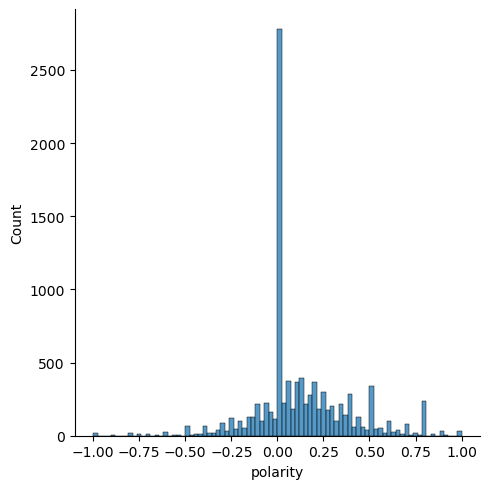

In [27]:
# histogram of polarity

# People may be descripting information factualy rather than. 
sns.displot(congress_tweets,         # specify data
            x="polarity") # x-axis label 
plt.show()

In [28]:
# Function to calculate subjectivity
def calculate_subjectivity(text):
    return TextBlob(text).sentiment.subjectivity

# Apply the function to your DataFrame if the 'subjectivity' column doesn't exist
if 'subjectivity' not in congress_tweets.columns:
    congress_tweets['subjectivity'] = congress_tweets['text_str'].apply(calculate_subjectivity)


In [29]:
# view
congress_tweets.head(100)

,tweet_id,screen_name,datetime,text,name_wikipedia,position,joined_congress_date,birthday,gender,state,...,trump_2016_state_share,clinton_2016_state_share,obama_2012_state_share,romney_2012_state_share,tokens,text_len,word_count,text_str,polarity,subjectivity
11361,1.132820e+18,SenDanSullivan,2019-05-26T21:36:32-04:00,Sam &amp; the guys had to deal with a less exp...,Dan Sullivan,Sen,3-Jan-15,11/13/1964,M,AK,...,"163,387","116,454","122,640","164,676",Sam guys deal experienced teammate But podium ...,281,48,Sam guys deal experienced teammate But podium ...,0.400000,0.533333
479436,1.125490e+18,SenatorFischer,2019-05-06T16:15:46-04:00,It was great to @Skype w @StuartPublicSch’s go...,Deb Fischer,Sen,3-Jan-13,3/1/1951,F,NE,...,"495,961","284,494","302,081","475,064",It great Skype w StuartPublicSch government cl...,357,42,It great Skype w StuartPublicSch government cl...,0.733333,0.683333
866557,1.166860e+18,RepDonBeyer,2019-08-28T19:44:44-04:00,RT @brianstelter 170 days.\n\nhttp://www.cnn.c...,Don Beyer,Rep,3-Jan-15,6/20/1950,M,VA,...,"1,769,443","1,981,473","1,971,820","1,822,522",brianstelter 170 days \n\n,116,5,brianstelter 170 days \n\n,0.000000,0.000000
168486,1.242860e+18,SenatorBennet,2020-03-25T13:14:12-04:00,@SenateDems We fought hard to make sure nonpro...,Michael Bennet,Sen,21-Jan-09,11/28/1964,M,CO,...,"1,202,484","1,338,870","1,323,102","1,185,243",SenateDems We fought hard sure nonprofits size...,217,34,SenateDems We fought hard sure nonprofits size...,0.085417,0.474306
507812,1.126490e+18,RepSires,2019-05-09T10:26:11-04:00,This illegal act shows once again there is no ...,Albio Sires,Rep,3-Jan-13,1/26/1951,M,NJ,...,"1,601,933","2,148,278","2,125,101","1,477,568",This illegal act shows rule law Maduro Venezue...,206,36,This illegal act shows rule law Maduro Venezue...,-0.500000,0.500000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
417215,1.120770e+18,RepHaleyStevens,2019-04-23T15:39:13-04:00,"Today, I had the honor of hosting three of Mic...",Haley Stevens,Rep,3-Jan-19,6/24/1983,F,MI,...,"2,279,543","2,268,839","2,564,569","2,115,256",Today I honor hosting Michigan leading experts...,423,31,Today I honor hosting Michigan leading experts...,0.400000,1.000000
816750,1.269690e+18,RepKayGranger,2020-06-07T14:00:00-04:00,Attention #ParkerCounty small business owners:...,Kay Granger,Rep,3-Jan-97,1/18/1943,F,TX,...,"4,685,047","3,877,868","3,308,124","4,569,843",Attention ParkerCounty small business owners A...,285,33,Attention ParkerCounty small business owners A...,0.007273,0.530909
306943,1.302060e+18,SenDuckworth,2020-09-04T21:49:56-04:00,When only 30% of our troops who have experienc...,Tammy Duckworth,Sen,3-Jan-17,3/12/1968,F,IL,...,"2,146,015","3,090,729","3,019,512","2,135,216",When 30 troops experienced sexual assault actu...,269,48,When 30 troops experienced sexual assault actu...,0.200000,0.405556
547830,1.318920e+18,MartinHeinrich,2020-10-21T10:06:39-04:00,The Trump administration's tactics against mig...,Martin Heinrich,Sen,3-Jan-13,10/17/1971,M,NM,...,"319,667","385,234","415,335","335,788",The Trump administrations tactics migrant chil...,529,53,The Trump administrations tactics migrant chil...,-0.400000,0.775000


In [30]:
exemplar_liberal_tweets = congress_tweets[congress_tweets['name_wikipedia'] == 'Alexandria Ocasio-Cortez']
exemplar_conservative_tweets = congress_tweets[congress_tweets['name_wikipedia'] == 'Ted Cruz']

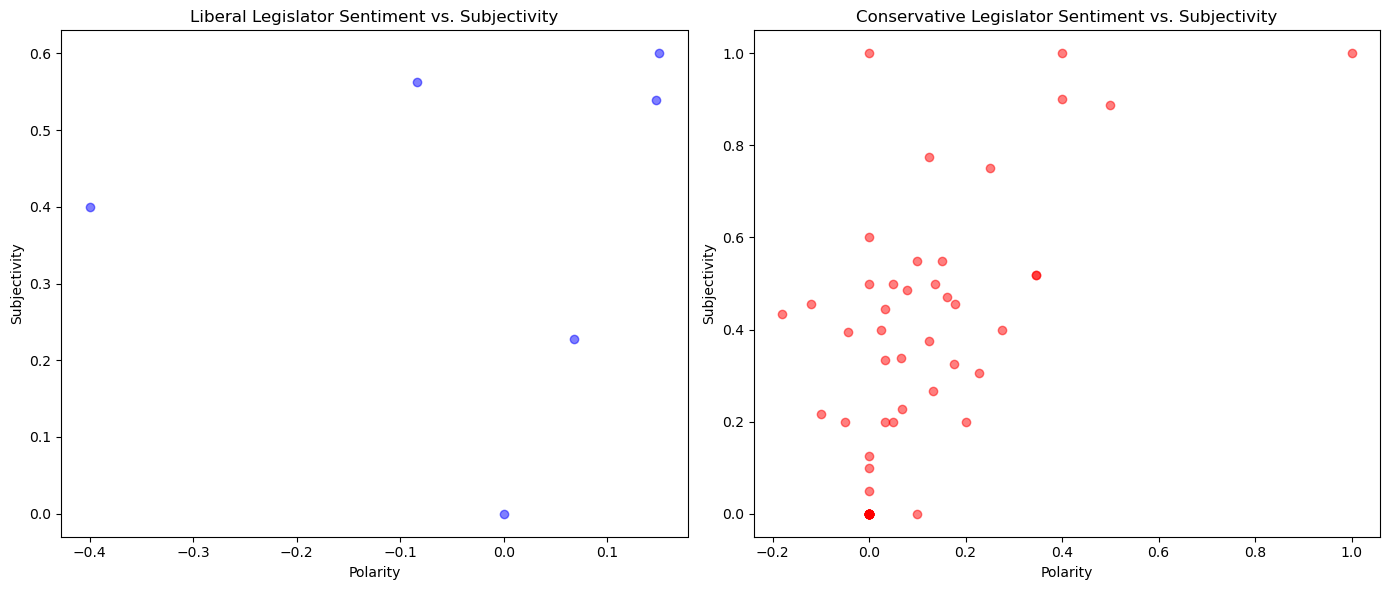

In [31]:
plt.figure(figsize=(14, 6))

# Liberal Legislator
plt.subplot(1, 2, 1)
plt.scatter(exemplar_liberal_tweets['polarity'], exemplar_liberal_tweets['subjectivity'], color='blue', alpha=0.5)
plt.title('Liberal Legislator Sentiment vs. Subjectivity')
plt.xlabel('Polarity')
plt.ylabel('Subjectivity')

# Conservative Legislator
plt.subplot(1, 2, 2)
plt.scatter(exemplar_conservative_tweets['polarity'], exemplar_conservative_tweets['subjectivity'], color='red', alpha=0.5)
plt.title('Conservative Legislator Sentiment vs. Subjectivity')
plt.xlabel('Polarity')
plt.ylabel('Subjectivity')

plt.tight_layout()
plt.show()


In [32]:
exemplar_liberal_tweets['Group'] = 'Liberal'
exemplar_conservative_tweets['Group'] = 'Conservative'

/var/folders/c7/nfgz1lbj0qv07p6y15ns31qr0000gn/T/ipykernel_22363/1670471360.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  exemplar_liberal_tweets['Group'] = 'Liberal'
/var/folders/c7/nfgz1lbj0qv07p6y15ns31qr0000gn/T/ipykernel_22363/1670471360.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  exemplar_conservative_tweets['Group'] = 'Conservative'


In [33]:
combined_tweets = pd.concat([exemplar_liberal_tweets, exemplar_conservative_tweets])

/Users/jr/Desktop/anaconda3/envs/CSS/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


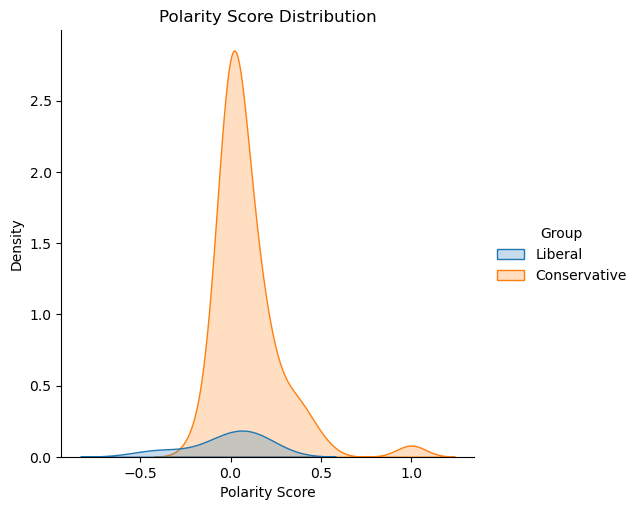

In [34]:
sns.displot(combined_tweets,       # data
            x='polarity',  # Assuming 'sentiment_score' is your numeric feature
            hue='Group',          # Differentiate by group
            kind='kde',           # Kernel Density Estimate plot
            fill=True)            # Fill under the KDE curves

plt.title('Polarity Score Distribution')
plt.xlabel('Polarity Score')
plt.ylabel('Density')
plt.show()

In [35]:
general_liberal_tweets = congress_tweets[congress_tweets['party'] == 'Democrat']
general_conservative_tweets = congress_tweets[congress_tweets['party'] == 'Republican']

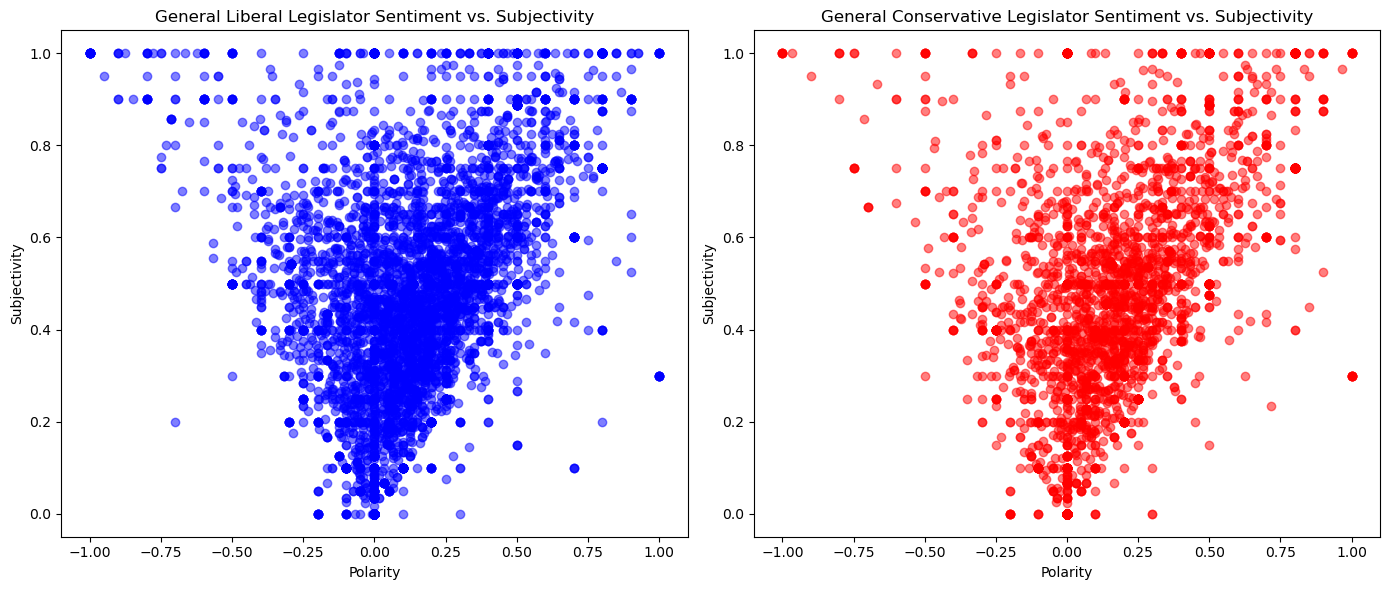

In [36]:
plt.figure(figsize=(14, 6))

# General Liberal Legislator
plt.subplot(1, 2, 1)
plt.scatter(general_liberal_tweets['polarity'], general_liberal_tweets['subjectivity'], color='blue', alpha=0.5)
plt.title('General Liberal Legislator Sentiment vs. Subjectivity')
plt.xlabel('Polarity')
plt.ylabel('Subjectivity')

# General Conservative Legislator
plt.subplot(1, 2, 2)
plt.scatter(general_conservative_tweets['polarity'], general_conservative_tweets['subjectivity'], color='red', alpha=0.5)
plt.title('General Conservative Legislator Sentiment vs. Subjectivity')
plt.xlabel('Polarity')
plt.ylabel('Subjectivity')

plt.tight_layout()
plt.show()


In [37]:
general_liberal_tweets['Group'] = 'General Liberal'
general_conservative_tweets['Group'] = 'General Conservative'

/var/folders/c7/nfgz1lbj0qv07p6y15ns31qr0000gn/T/ipykernel_22363/548948063.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  general_liberal_tweets['Group'] = 'General Liberal'
/var/folders/c7/nfgz1lbj0qv07p6y15ns31qr0000gn/T/ipykernel_22363/548948063.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  general_conservative_tweets['Group'] = 'General Conservative'


In [38]:
general_combined_tweets = pd.concat([general_liberal_tweets, general_conservative_tweets])

/Users/jr/Desktop/anaconda3/envs/CSS/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


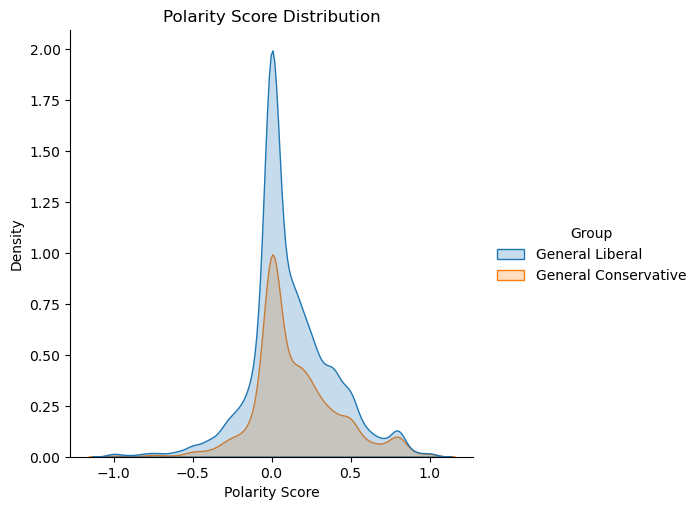

In [39]:
sns.displot(general_combined_tweets,       # data
            x='polarity',  # Assuming 'sentiment_score' is your numeric feature
            hue='Group',          # Differentiate by group
            kind='kde',           # Kernel Density Estimate plot
            fill=True)            # Fill under the KDE curves

plt.title('Polarity Score Distribution')
plt.xlabel('Polarity Score')
plt.ylabel('Density')
plt.show()

In [40]:
sen_tweets = congress_tweets[congress_tweets['position'] == 'Sen']
rep__tweets = congress_tweets[congress_tweets['position'] == 'Rep']

In [41]:
sen_tweets['Group'] = 'Senators'
rep__tweets['Group'] = 'Reps'

/var/folders/c7/nfgz1lbj0qv07p6y15ns31qr0000gn/T/ipykernel_22363/3136849349.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sen_tweets['Group'] = 'Senators'
/var/folders/c7/nfgz1lbj0qv07p6y15ns31qr0000gn/T/ipykernel_22363/3136849349.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rep__tweets['Group'] = 'Reps'


In [42]:
general_position_tweets = pd.concat([sen_tweets, rep__tweets])

/Users/jr/Desktop/anaconda3/envs/CSS/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


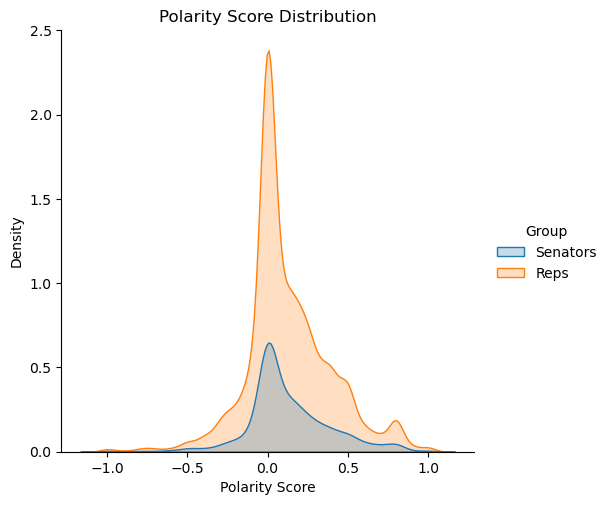

In [43]:
sns.displot(general_position_tweets,       # data
            x='polarity',  # Assuming 'sentiment_score' is your numeric feature
            hue='Group',          # Differentiate by group
            kind='kde',           # Kernel Density Estimate plot
            fill=True)            # Fill under the KDE curves

plt.title('Polarity Score Distribution')
plt.xlabel('Polarity Score')
plt.ylabel('Density')
plt.show()

## Featurization

Before going to classification, explore different featurization techniques. Create three dataframes or arrays to represent your text features, specifically:

* Features engineered from your previous analysis. For example, word counts, sentiment scores, topic model etc.
* A term frequency-inverse document frequency matrix. 
* An embedding-based featurization (like a document averaged word2vec)

In the next section, you will experiment with each of these featurization techniques to see which one produces the best classifications.

In [44]:
congress_tweets.columns

Index(['tweet_id', 'screen_name', 'datetime', 'text', 'name_wikipedia',
       'position', 'joined_congress_date', 'birthday', 'gender', 'state',
       'district_number', 'party', 'trump_2016_state_share',
       'clinton_2016_state_share', 'obama_2012_state_share',
       'romney_2012_state_share', 'tokens', 'text_len', 'word_count',
       'text_str', 'polarity', 'subjectivity'],
      dtype='object')

### Engineered Text Features

In [45]:


# Engineered Text Features
# --------
# select engineered text features
engineered_features = congress_tweets[['text_len', 
                                       'word_count', 
                                       'polarity', 
                                       'subjectivity']].reset_index(drop = True)








In [46]:
engineered_features

,text_len,word_count,polarity,subjectivity
0,281,48,0.400000,0.533333
1,357,42,0.733333,0.683333
2,116,5,0.000000,0.000000
3,217,34,0.085417,0.474306
4,206,36,-0.500000,0.500000
...,...,...,...,...
9995,46,1,0.000000,0.000000
9996,733,86,0.076984,0.213492
9997,670,71,-0.333333,0.675000
9998,321,36,-0.016667,0.650000


### Bag-of-words or Tf-idf

In [47]:
# Frequency Based featurization
...

In [48]:
# first, let's define a function to print the top words that we'll use in our model
# --------

def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("\nTopic #{}:".format(topic_idx))
        print(" ".join([feature_names[i]
                        for i in topic.argsort()[:-n_top_words - 1:-1]]))
    print()

In [49]:
# pre-processing
# --------
# create a new data object called X
X = congress_tweets['tokens']

In [50]:
X

11361     Sam guys deal experienced teammate But podium ...
479436    It great Skype w StuartPublicSch government cl...
866557                           brianstelter 170 days \n\n
168486    SenateDems We fought hard sure nonprofits size...
507812    This illegal act shows rule law Maduro Venezue...
                                ...                        
261279                                                     
697356    1200 NOT Americans wo nt survive crisis single...
86697     We opportunity work address California water p...
439953    MN meeting federal clean air standards air pol...
73974     Meet Cora She s constituent Kern County Califo...
Name: tokens, Length: 10000, dtype: object

In [51]:
# initialize tf-idf function and set parameters
tf = TfidfVectorizer(tokenizer = rem_punc_stop,  # specify our function for remove punc and stop words
                     token_pattern = None)       # specify "None" to remove warning. Is this necessary?


In [52]:
# apply tf-idf vectorizer to our data (X)
tfidf_matrix =  tf.fit_transform(X)

In [53]:
# modify the output to be a dense matrix
dense_matrix = tfidf_matrix.todense()

In [54]:
# create dataframe of tf-idf 
tfidf_df = pd.DataFrame(tfidf_matrix.todense(),                # specify matrix
                        columns = tf.get_feature_names_out())  # set feature names

First Two Models

In [55]:
pip install scikit-learn

Note: you may need to restart the kernel to use updated packages.


In [56]:
from sklearn.preprocessing import LabelBinarizer

In [57]:

# create a list of dataframes from the objects created above
dataframes = [engineered_features, 
              tfidf_df]


# create a list of labeles based on the objects created above
featurization_technique = ['Engineered Text Features',
                           'Tf-idf Features']


# model initalization and fit
# --------

# initalize binarizer
lb_style = LabelBinarizer()

# fit LabelBinarizer to our data. Esiamting prbability of being withing either party. 
y = congress_tweets['party'] = lb_style.fit_transform(congress_tweets["party"])


In [58]:
y.shape

(10000, 3)

In [59]:
pip install scikit-learn

Note: you may need to restart the kernel to use updated packages.


In [60]:
from sklearn.model_selection import train_test_split

In [61]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix

In [62]:
from sklearn.metrics import confusion_matrix

In [65]:
# loop over each dataframe, apply a logit classification model, and create a confusion matrix
# --------
for dataframe, featurization in zip(dataframes, featurization_technique):
    
    # changing column names to strings because some are integer
    dataframe.columns = dataframe.columns.astype(str) 
    
    # split data
    # ----------
    X_train, X_test, y_train, y_test = train_test_split(dataframe,         # specify features
                                                        y,                 # specify labels
                                                        train_size = .80,  # specify train split of 80%
                                                        test_size=0.20,    # specify test split of 20%
                                                        random_state = 10) # set seed for reproducibility
    # apply Logit model 
    # ----------
    # initalize Logit model 
    logit_reg = LogisticRegression() # set max_iter = 500

    # fit the model to our data
    logit_model = logit_reg.fit(X_train,         # specify feature data
                                y_train.ravel()) # specify label data --- don't forget to ravel the label dataset. Restructres the matrix to an array.

    # predict on test set
    y_pred = logit_model.predict(X_test)
    
    # create a confusion matrix
    # ----------
    cf_matrix = confusion_matrix(y_test,             # specify test
                                 y_pred,             # specify predicted
                                 normalize = "true") # normalize

    # create a pandas dataframe from the confusion matrix for visualization 
    df_cm = pd.DataFrame(cf_matrix,          # specify cf_matrix from which to create dataframe 
                         range(2), range(2)) # set 2 by 2 

    # set confusion matrix indices for clarity of visualization
    df_cm = df_cm.rename(index=str, 
                         columns={0: "Democrat", 
                                  1: "Republican"})

    # specify confusion matrix index for clarity
    df_cm.index = ["Democrat", "Republican"]
    
    # figure specifications 
    plt.figure(figsize = (10,7)) # set figure size specifications
    sns.set(font_scale=1.4)      # set label size
    sns.heatmap(df_cm,           # specify dataset
                annot=True,    
                annot_kws={"size": 16},
                fmt='g')
    
    # figure labels
    plt.title(featurization)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.show()

ValueError: Found input variables with inconsistent numbers of samples: [8000, 24000]

Position Models

In [66]:
# create a list of dataframes from the objects created above
dataframes = [engineered_features, 
              tfidf_df]


# create a list of labeles based on the objects created above
featurization_technique = ['Engineered Text Features',
                           'Tf-idf Features']


# model initalization and fit
# --------

# initalize binarizer
lb_style = LabelBinarizer()

# fit LabelBinarizer to our data. Esiamting prbability of being withing either party. 
y = congress_tweets['position'] = lb_style.fit_transform(congress_tweets["position"])

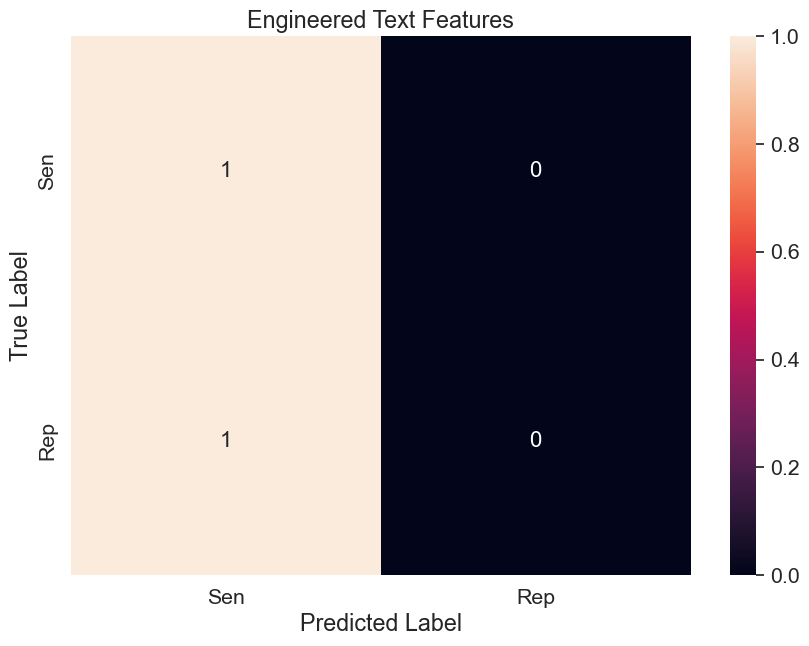

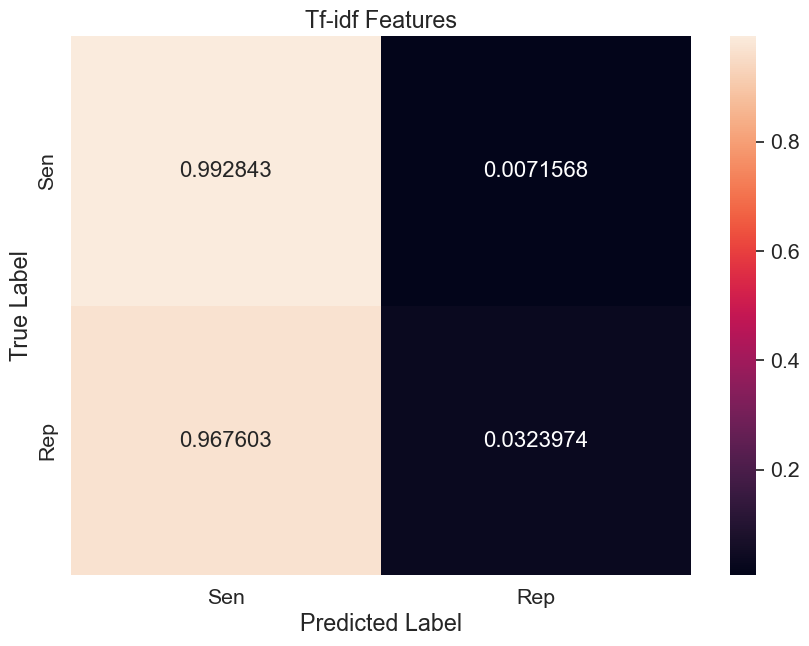

In [67]:
# loop over each dataframe, apply a logit classification model, and create a confusion matrix
# --------
for dataframe, featurization in zip(dataframes, featurization_technique):
    
    # changing column names to strings because some are integer
    dataframe.columns = dataframe.columns.astype(str) 
    
    # split data
    # ----------
    X_train, X_test, y_train, y_test = train_test_split(dataframe,         # specify features
                                                        y,                 # specify labels
                                                        train_size = .80,  # specify train split of 80%
                                                        test_size=0.20,    # specify test split of 20%
                                                        random_state = 10) # set seed for reproducibility
    # apply Logit model 
    # ----------
    # initalize Logit model 
    logit_reg = LogisticRegression() # set max_iter = 500

    # fit the model to our data
    logit_model = logit_reg.fit(X_train,         # specify feature data
                                y_train.ravel()) # specify label data --- don't forget to ravel the label dataset. Restructres the matrix to an array.

    # predict on test set
    y_pred = logit_model.predict(X_test)
    
    # create a confusion matrix
    # ----------
    cf_matrix = confusion_matrix(y_test,             # specify test
                                 y_pred,             # specify predicted
                                 normalize = "true") # normalize

    # create a pandas dataframe from the confusion matrix for visualization 
    df_cm = pd.DataFrame(cf_matrix,          # specify cf_matrix from which to create dataframe 
                         range(2), range(2)) # set 2 by 2 

    # set confusion matrix indices for clarity of visualization
    df_cm = df_cm.rename(index=str, 
                         columns={0: "Sen", 
                                  1: "Rep"})

    # specify confusion matrix index for clarity
    df_cm.index = ["Sen", "Rep"]
    
    # figure specifications 
    plt.figure(figsize = (10,7)) # set figure size specifications
    sns.set(font_scale=1.4)      # set label size
    sns.heatmap(df_cm,           # specify dataset
                annot=True,    
                annot_kws={"size": 16},
                fmt='g')
    
    # figure labels
    plt.title(featurization)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.show()

### Word Embedding

In [68]:
import os
print(os.getcwd())


/Users/jr/Desktop/Draft_HWs_CompSS/Computational-Social-Science-Training-Program/Projects/Project 5


In [69]:
import gensim

In [70]:
model = gensim.models.KeyedVectors.load_word2vec_format('/Users/jr/Desktop/Draft_HWs_CompSS/Computational-Social-Science-Training-Program/data/GoogleNews-vectors-negative300.bin', binary=True)


In [71]:
# Function to average word embeddings for a document; use examples from lab to apply this function. You can use also other techniques such as PCA and doc2vec instead.
#def document_vector(word2vec_model, doc):
 #   doc = [word for word in doc if word in model.vocab]
  #  return np.mean(model[doc], axis=0)

In [72]:
import numpy as np

def document_vector(word2vec_model, doc):
    # Adjusted to use .key_to_index for Gensim 4.0.0 compatibility
    doc = [word for word in doc if word in word2vec_model.key_to_index]
    if len(doc) == 0:
        return np.zeros(word2vec_model.vector_size)  # Return a zero vector if doc is empty
    return np.mean(word2vec_model[doc], axis=0)

# Assuming `model` is your word2vec model and `congress_tweets['tokens']` is a list of tokens for each document
empty_list_embeddings_means = []

# Loop over each document's tokens and append the vector for each document
for doc in congress_tweets['tokens']:
    empty_list_embeddings_means.append(document_vector(model, doc))

# Convert the list to an array
doc_average_embeddings = np.array(empty_list_embeddings_means)



In [73]:
# convert word embeddings into dataframe
# ----------
word2vec_features_df = pd.DataFrame(doc_average_embeddings)

In [75]:
import xgboost as xgb

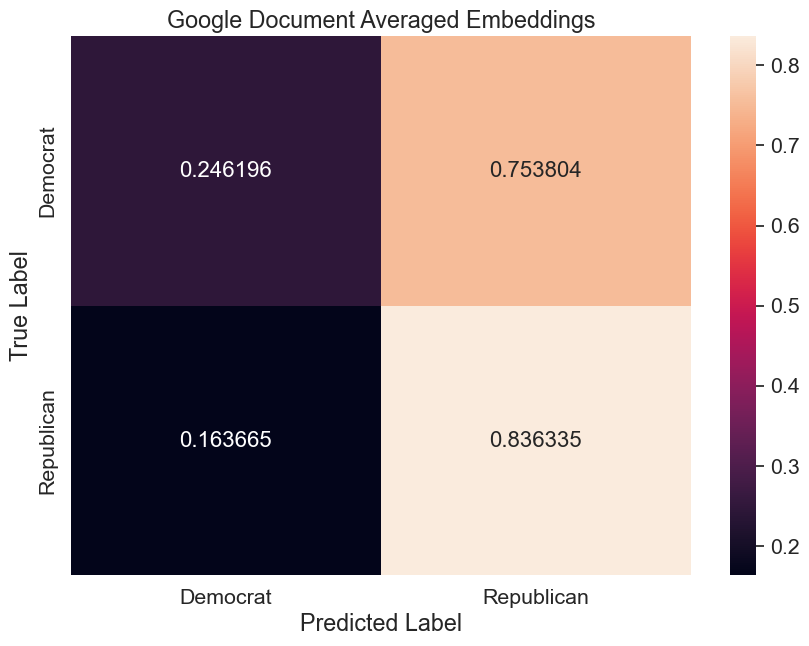

In [76]:
#
# Classifcation model
# ----------------------------------------


# specify logit model
# ----------

# create label
y = congress_tweets['party']

# split into training
X_train, X_test, y_train, y_test = train_test_split(word2vec_features_df, # specify features
                                                    y,                    # specify labels
                                                    train_size = .80,     # specify training split
                                                    test_size=0.20,       # specify test split
                                                    random_state = 10)    # set seed
# Initialize XGBoost model
xgb_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')
    
# Fit the model to our data
xgb_model.fit(X_train, y_train.ravel())
    
# Predict on test set
y_pred = xgb_model.predict(X_test)

# confusion matrix
# ----------

# create confusion matrix 
cf_matrix = confusion_matrix(y_test,              # actual
                             y_pred,              # predictions
                             normalize = "true")  # normalize

# create dataframe
df_cm = pd.DataFrame(cf_matrix,   # specify matrix for calculations
                     range(2),
                     range(2))

# rename indices
df_cm = df_cm.rename(index=str, columns={0: "Democrat", 
                                         1: "Republican"})

df_cm.index = ["Democrat", "Republican"]


# plot specifications
# ----------

plt.figure(figsize = (10,7))
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, 
           annot=True,
           annot_kws={"size": 16},
           fmt='g')

plt.title('Google Document Averaged Embeddings')
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

# XGBoost Word Embedding: Position

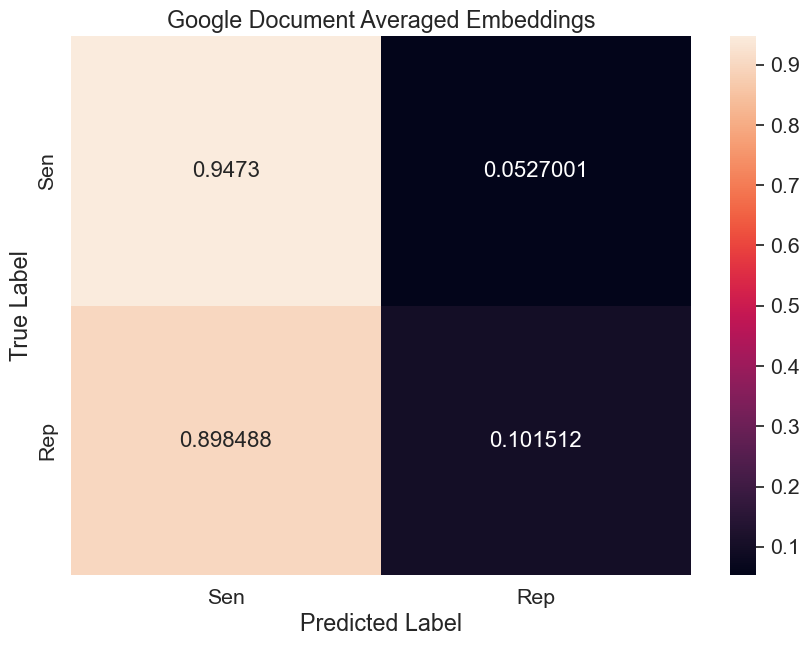

In [77]:
#
# Classifcation model
# ----------------------------------------


# specify logit model
# ----------

# create label
y = congress_tweets['position']

# split into training
X_train, X_test, y_train, y_test = train_test_split(word2vec_features_df, # specify features
                                                    y,                    # specify labels
                                                    train_size = .80,     # specify training split
                                                    test_size=0.20,       # specify test split
                                                    random_state = 10)    # set seed
# Initialize XGBoost model
xgb_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')
    
# Fit the model to our data
xgb_model.fit(X_train, y_train.ravel())
    
# Predict on test set
y_pred = xgb_model.predict(X_test)

# confusion matrix
# ----------

# create confusion matrix 
cf_matrix = confusion_matrix(y_test,              # actual
                             y_pred,              # predictions
                             normalize = "true")  # normalize

# create dataframe
df_cm = pd.DataFrame(cf_matrix,   # specify matrix for calculations
                     range(2),
                     range(2))

# rename indices
df_cm = df_cm.rename(index=str, columns={0: "Sen", 
                                         1: "Rep"})

df_cm.index = ["Sen", "Rep"]


# plot specifications
# ----------

plt.figure(figsize = (10,7))
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, 
           annot=True,
           annot_kws={"size": 16},
           fmt='g')

plt.title('Google Document Averaged Embeddings')
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

# Two Best Models

In [78]:



# select non-text features
non_text_features = congress_tweets[[ 
                          'datetime', 
                          'joined_congress_date', 
                          'birthday',
                          'gender',
                          'state',
                          'district_number',
                          'trump_2016_state_share',
                          'clinton_2016_state_share',
                          'obama_2012_state_share',
                          'romney_2012_state_share']]

# get dummies of non-text features
non_text_features_dummies = pd.get_dummies(non_text_features).reset_index(drop = True)



In [79]:
# Initialize binarizer for the party column
lb_style = LabelBinarizer()

# Fit LabelBinarizer to our data. Estimating probability of being Democrat (assuming binary outcome: Democrat or Republican)
y = lb_style.fit_transform(congress_tweets["party"])

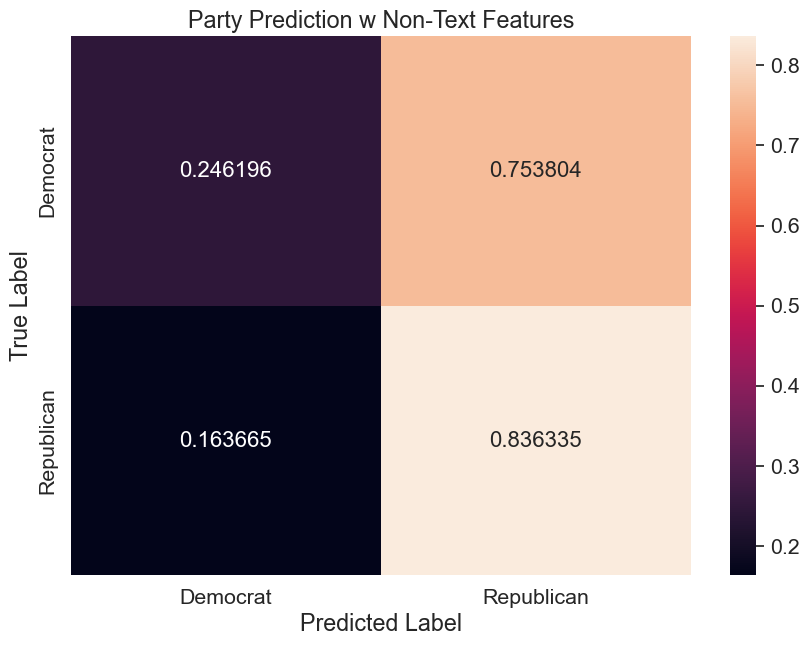

In [80]:

dataframe = non_text_features_dummies

# Change column names to strings in case some are integers
dataframe.columns = dataframe.columns.astype(str)

# split into training
X_train, X_test, y_train, y_test = train_test_split(word2vec_features_df, # specify features
                                                    y,                    # specify labels
                                                    train_size = .80,     # specify training split
                                                    test_size=0.20,       # specify test split
                                                    random_state = 10)    # set seed
# Initialize XGBoost model
xgb_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')
    
# Fit the model to our data
xgb_model.fit(X_train, y_train.ravel())
    
# Predict on test set
y_pred = xgb_model.predict(X_test)


# confusion matrix
# ----------

# create confusion matrix 
cf_matrix = confusion_matrix(y_test,              # actual
                             y_pred,              # predictions
                             normalize = "true")  # normalize

# create dataframe
df_cm = pd.DataFrame(cf_matrix,   # specify matrix for calculations
                     range(2),
                     range(2))

# rename indices
df_cm = df_cm.rename(index=str, columns={0: "Democrat", 
                                         1: "Republican"})

df_cm.index = ["Democrat", "Republican"]


# plot specifications
# ----------

plt.figure(figsize = (10,7))
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, 
           annot=True,
           annot_kws={"size": 16},
           fmt='g')

plt.title('Party Prediction w Non-Text Features')
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

In [81]:
# Initialize binarizer for the party column
lb_style = LabelBinarizer()

# Fit LabelBinarizer to our data. Estimating probability of being Democrat (assuming binary outcome: Democrat or Republican)
y = lb_style.fit_transform(congress_tweets["position"])

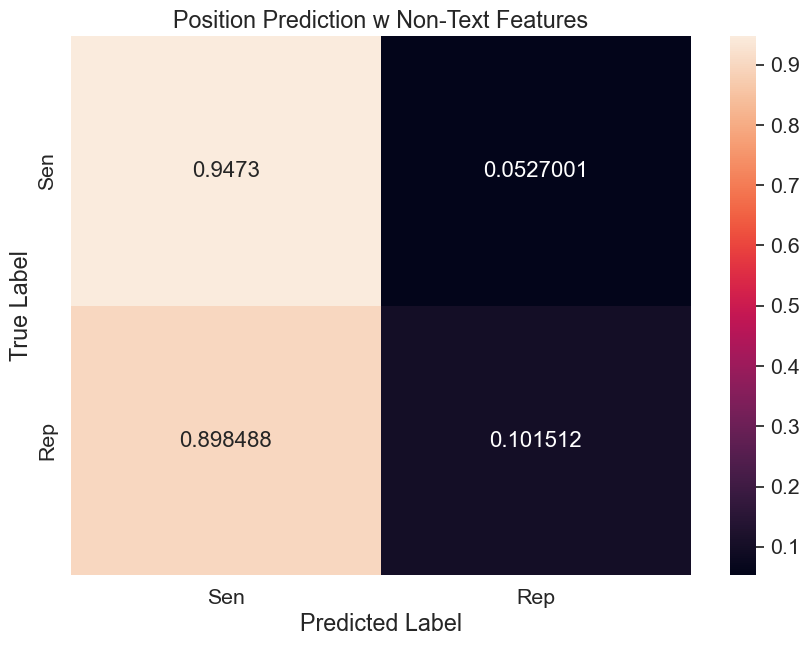

In [82]:
dataframe = non_text_features_dummies

# Change column names to strings in case some are integers
dataframe.columns = dataframe.columns.astype(str)

# split into training
X_train, X_test, y_train, y_test = train_test_split(word2vec_features_df, # specify features
                                                    y,                    # specify labels
                                                    train_size = .80,     # specify training split
                                                    test_size=0.20,       # specify test split
                                                    random_state = 10)    # set seed
# Initialize XGBoost model
xgb_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')
    
# Fit the model to our data
xgb_model.fit(X_train, y_train.ravel())
    
# Predict on test set
y_pred = xgb_model.predict(X_test)


# confusion matrix
# ----------

# create confusion matrix 
cf_matrix = confusion_matrix(y_test,              # actual
                             y_pred,              # predictions
                             normalize = "true")  # normalize

# create dataframe
df_cm = pd.DataFrame(cf_matrix,   # specify matrix for calculations
                     range(2),
                     range(2))

# rename indices
df_cm = df_cm.rename(index=str, columns={0: "Sen", 
                                         1: "Rep"})

df_cm.index = ["Sen", "Rep"]


# plot specifications
# ----------

plt.figure(figsize = (10,7))
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, 
           annot=True,
           annot_kws={"size": 16},
           fmt='g')

plt.title('Position Prediction w Non-Text Features')
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

In [83]:

# combine non-text features with word2vec  
non_text_plus_word2vec_df = non_text_features_dummies.reset_index(drop = True).join(word2vec_features_df)

In [84]:
# Initialize binarizer for the party column
lb_style = LabelBinarizer()

# Fit LabelBinarizer to our data. Estimating probability of being Democrat (assuming binary outcome: Democrat or Republican)
y = lb_style.fit_transform(congress_tweets["party"])

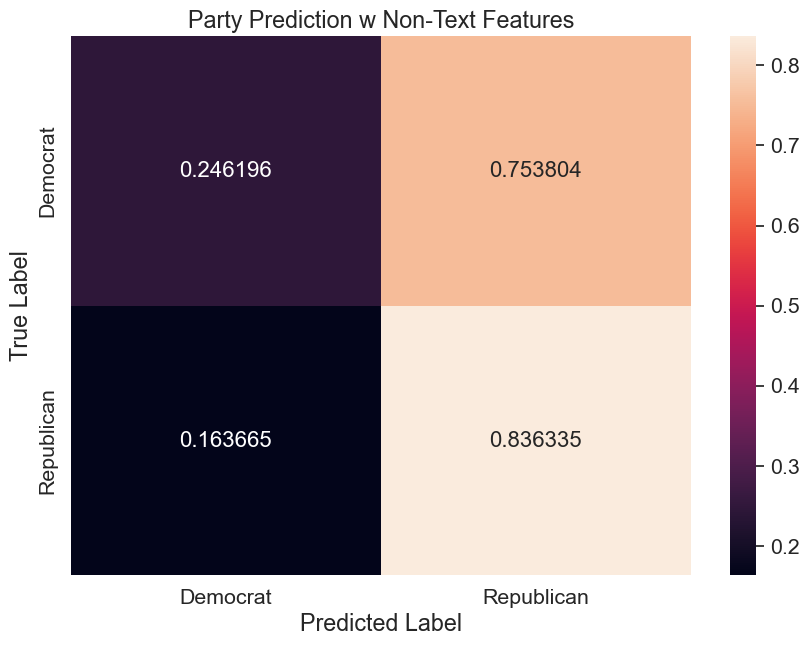

In [85]:
dataframe = non_text_plus_word2vec_df

# Change column names to strings in case some are integers
dataframe.columns = dataframe.columns.astype(str)

# split into training
X_train, X_test, y_train, y_test = train_test_split(word2vec_features_df, # specify features
                                                    y,                    # specify labels
                                                    train_size = .80,     # specify training split
                                                    test_size=0.20,       # specify test split
                                                    random_state = 10)    # set seed
# Initialize XGBoost model
xgb_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')
    
# Fit the model to our data
xgb_model.fit(X_train, y_train.ravel())
    
# Predict on test set
y_pred = xgb_model.predict(X_test)


# confusion matrix
# ----------

# create confusion matrix 
cf_matrix = confusion_matrix(y_test,              # actual
                             y_pred,              # predictions
                             normalize = "true")  # normalize

# create dataframe
df_cm = pd.DataFrame(cf_matrix,   # specify matrix for calculations
                     range(2),
                     range(2))

# rename indices
df_cm = df_cm.rename(index=str, columns={0: "Democrat", 
                                         1: "Republican"})

df_cm.index = ["Democrat", "Republican"]


# plot specifications
# ----------

plt.figure(figsize = (10,7))
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, 
           annot=True,
           annot_kws={"size": 16},
           fmt='g')

plt.title('Party Prediction w Non-Text Features')
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

In [86]:
# Initialize binarizer for the party column
lb_style = LabelBinarizer()

# Fit LabelBinarizer to our data. Estimating probability of being Democrat (assuming binary outcome: Democrat or Republican)
y = lb_style.fit_transform(congress_tweets["position"])

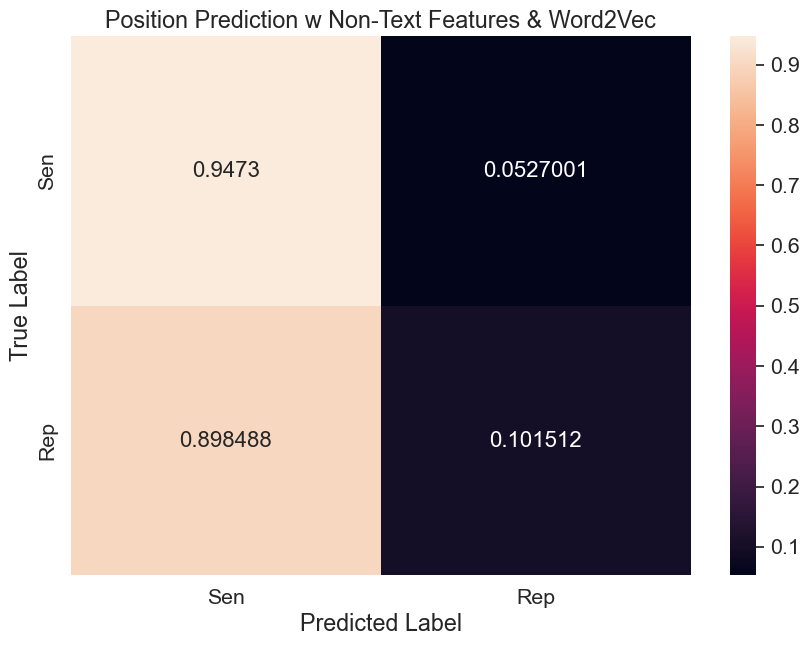

In [87]:
dataframe = non_text_plus_word2vec_df

# Change column names to strings in case some are integers
dataframe.columns = dataframe.columns.astype(str)

# split into training
X_train, X_test, y_train, y_test = train_test_split(word2vec_features_df, # specify features
                                                    y,                    # specify labels
                                                    train_size = .80,     # specify training split
                                                    test_size=0.20,       # specify test split
                                                    random_state = 10)    # set seed
# Initialize XGBoost model
xgb_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')
    
# Fit the model to our data
xgb_model.fit(X_train, y_train.ravel())
    
# Predict on test set
y_pred = xgb_model.predict(X_test)


# confusion matrix
# ----------

# create confusion matrix 
cf_matrix = confusion_matrix(y_test,              # actual
                             y_pred,              # predictions
                             normalize = "true")  # normalize

# create dataframe
df_cm = pd.DataFrame(cf_matrix,   # specify matrix for calculations
                     range(2),
                     range(2))

# rename indices
df_cm = df_cm.rename(index=str, columns={0: "Sen", 
                                         1: "Rep"})

df_cm.index = ["Sen", "Rep"]


# plot specifications
# ----------

plt.figure(figsize = (10,7))
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, 
           annot=True,
           annot_kws={"size": 16},
           fmt='g')

plt.title('Position Prediction w Non-Text Features & Word2Vec')
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

## Classification

Either use cross-validation or partition your data with training/validation/test sets for this section. Do the following:

* Choose a supervised learning algorithm such as logistic regression, random forest etc. 
* Train six models. For each of the three dataframes you created in the featurization part, train one model to predict whether the author of the tweet is a Democrat or Republican, and a second model to predict whether the author is a Senator or Representative.
* Report the accuracy and other relevant metrics for each of these six models.
* Choose the featurization technique associated with your best model. Combine those text features with non-text features. Train two more models: (1) A supervised learning algorithm that uses just the non-text features and (2) a supervised learning algorithm that combines text and non-text features. Report accuracy and other relevant metrics. 

If time permits, you are encouraged to use hyperparameter tuning or AutoML techniques like TPOT, but are not explicitly required to do so.

### Train Six Models with Just Text

In [ ]:
# six models ([engineered features, frequency-based, embedding] * [democrat/republican, senator/representative])
...

### Two Combined Models

In [88]:
# two models ([best text features + non-text features] * [democrat/republican, senator/representative])
...

## Discussion Questions

1. Why do standard preprocessing techniques need to be further customized to a particular corpus?

While there ample reasons why one would. want to adjust the preprocessing technique and work flow three primary reasons could relate to domain sepcific vocabualry, document format specifc vocabulary as well as your analytical goals. For domain knowledge we may be most concerned with hyper specific taht only have meaning within this contet or take on anew meaninging with the context youa re working within. Similarly the format we find our tokens in can vary greatly by the format that could for example change the formaility of the document or for example as we can see in tweets the length of sequecne of words thus altering how language is comunicated and then received. Ofcourse the primary consideration we mayhave as researchers can from the objective of out line of inquiry. 



2. Did you find evidence for the idea that Democrats and Republicans have different sentiments in their tweets? What about Senators and Representatives?

We fail to reject the null that ther is no difference in polarity of sentiments between democrat and republicans. The difference we see when we plot our data is one of density rather than the scoring of sentiments. Now we could be skeptical on the ability of the polarity score to capture distinct sentiment between the two particualry when we use our html visualization. For example if one reviews the document you can see the Demcorats have terms that refer back to an ethic of bipatisianship while republicans frequently use the names of specific dem legislators in a critical light and calls out democrats by their names frequently. What would also be intersting to see is if there was diffrence between challengers and incumbents or perhaps if we had longer data over time genrational differnces between when members are elected. 

3. Why is validating your exploratory and unsupervised learning approaches with a supervised learning algorithm valuable?

Validating exploratory and unsupervised learning methods with supervised algorithms is essential for several reasons. First, it establishes a quantitative benchmark, allowing for an objective evaluation of the unsupervised models' ability to uncover meaningful patterns. This validation process ensures that the insights and patterns identified have practical relevance by confirming their predictive power regarding known outcomes. Moreover, it guides the refinement of unsupervised models by aligning feature selection and model parameters more closely with real-world data and domain knowledge, thereby enhancing both accuracy and reliability. Essentially, this cross-validation bridges the gap between exploratory analysis and actionable, evidence-based conclusions.

4. Did text only, non-text only, or text and non-text features together perform the best? What is the intuition behind combining text and non-text features in a supervised learning algorithm?

In our analysis of tweets, we observed that models incorporating both text and non-text features slightly outperformed those based solely on one type of feature. However, the improvement in performance was not substantial and came with trade-offs in terms of what specific metric we were looking at for evaluation. This nuanced improvement suggests that while combining different types of data can provide a more holistic view of the content, the gains must be weighed against the costs, especially concerning specific metrics such as precision or recall. Moreover, the marginal performance enhancement and the challenges faced in model optimization are likely exacerbated by the small and unbalanced nature of our sample. This limitation underscores the importance of a well-sized and representative dataset for training, as the intricacies of tweets—with their rich, contextual robustness and balanced data to fully harness the potential of combined feature sets.